## Neural Networks and Deep Learning

In [113]:
# Run this cell only once. You can use your preferred package manager to download the pyTorch.  
# Refer to the official documentation.
#! pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu

In [114]:
import torch
from torchvision import datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader as DataLoader
from torchvision import transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

### A first look at a neural network

Let's look at a fully-worked through example of a neural network built in *PyTorch*. The problem we will solve is a machine learning classic: classification of handwritten digits with the MNIST dataset.

First, let's define the problem: We are trying to solve the classification of grayscale images of handwritten digits (28 x 28 pixels) into 10 categories (one through nine). In a grayscale image, each point in the two dimensional space has two values (a, b) assigned to it, where a and b range of 0 to 255. Or to put it simply, the pixel values fall in the range of 0 to 255. We begin by loading the dataset.

#### Preprocessing
The library works with tensors. Tensors are merely a generalisation of scalars and vectors; a scalar is a zero rank tensor, and a vector is a first rank tensor. So, in the first step, we convert the input images into tensors. For this, we will use the **torchvision.Transforms** package.

We will also noramlize the images since the deep learning models tend to work better when the input values are normalized [here](https://towardsdatascience.com/why-data-should-be-normalized-before-training-a-neural-network-c626b7f66c7d)

In [115]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize( (0.1307,), (0.3081,))])


We dwnload the MNIST dataset and create the train and test split. We have to use [this](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) api.

We load the train and test data set from MNIST

In [116]:
trainset = datasets.MNIST(root = 'MNIST', train = True, transform = transform, download = True)
testset = datasets.MNIST(root = 'MNIST', train = False, transform = transform, download = True)

#### Splitting the Dataset
Like a good data scientist, we would create a validation split from the training data. For this, we would set a fraction. This fraction would be stored in the variable `train_size`

In [117]:
train_size = 0.8

#### We split the trainset and create the validation split from it.

In [118]:
train_size= int(train_size*len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])
# train_dataset[0][0]

##### Batch Size 
We will use stochastic gradient descent (SGD)  for learning the model parameters. So, we would load a mini batch of data. We have set the value as 4 by default.

In [119]:
batch_size = 4

### TODO (1 point)

##### Dataloader
Next, we have to create a dataloader. We have one data loader for each of the data-splits. For the training data, the `shuffle` parameter should be set to `True` while for validation and test dataloaders, `shuffle` should be `False`. 

You have to use the [DataLoader class] (https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for this task

In [120]:
trainloader = DataLoader(dataset = trainset, batch_size = batch_size, shuffle = True)

valloader = DataLoader(dataset = valset, batch_size = batch_size, shuffle = False)

testloader = DataLoader(dataset = testset, batch_size = batch_size, shuffle = False)

##### Simple visualization
Let us quickly visualize some of the training samples.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


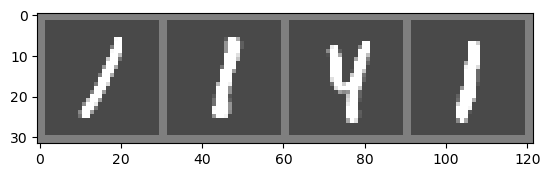

    1     1     4     1


In [121]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{labels[j]:5}' for j in range(batch_size)))

#### Check the shape of images. 
Since we will start with Fully Connected networks, we have to convert the image into a single vector. We will do that using the `reshape` function from PyTorch. 

In [122]:
images.shape # 4 

torch.Size([4, 1, 28, 28])

In [123]:
input_dim = images.reshape(batch_size, -1).shape[1]
input_dim

784

#### Structure 
So our network will receive a single vector of 784 dimensions and return a vector of 10 dimensions. The output shall correspond to how likely the vector represents a specific class. (The higher the value, the better) 



### A Fully Connected Network
Our network should have three linear layers. The last layer should have `out_features = num_classes`. We implement the `forward()` function, as  the processing happens in the forward function. We also use `F.relu()` for the non-linearity. The `in_channel` and `out_channel` should be integers.

In [124]:
class FCNetwork(nn.Module):
    def __init__(self, input_dim, num_classes=10):
        super().__init__()
        self.lin1 = nn.Linear(in_features = input_dim, out_features = input_dim//2) # input the 784 vector
        self.lin2 = nn.Linear(in_features = input_dim//2, out_features = input_dim//4)
        self.lin3 = nn.Linear(in_features = input_dim//4, out_features = num_classes) # defines number of classes

    def forward(self, x):
        x = self.lin1(x)
        # Apply ReLU
        x = F.relu(x)
        x = self.lin2(x)
        # Apply ReLU
        x = F.relu(x)
        x = self.lin3(x)
        return x
    
# as we convert image into vector, we lose information of locality --> CNNetworks better

In [125]:
network = FCNetwork(input_dim=input_dim, num_classes=10)

Now we create an optimizer and the loss function. We will use [CrossEntropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) as the loss function and [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD) as the optimizer.
We use a learning rate of `0.001` and play around with other parameters. Put `momentum` parameter as `0.9`.

In [126]:
# learnrate = .001, momentum = .9
params = list(network.parameters())
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params = params , lr = 0.001, momentum = 0.9)

In [127]:
PATH = '../../../files2large/mnist_net.pth'

Let's train the model:

In [128]:
# a lot of variations for the same optimizer, just select one of them
# this part is a sceleton for the use with pytorch 
min_val_loss = float("inf")
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    network.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # Reshape the inputs
        inputs = inputs.reshape(batch_size, -1)
        
        outputs = network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0


# how well is is it performing on the valodation set, once it starts to overfit its good?
# idea is to use the validation set to see when the learning process is finished an further learning would just lead to 
# overfitting. val set tells you when to stop.

    network.eval()
    val_loss = 0
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # Reshape the inputs
            inputs = inputs.reshape(batch_size, -1)
            
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            # print statistics
            val_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {val_loss / 2000:.3f}')
                val_loss = 0.0
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        print(f"The new best model is at epoch {epoch}")
        torch.save(network.state_dict(), PATH)
    print(f'Epoch: {epoch} over')
    

[1,  2000] loss: 0.584
[1,  4000] loss: 0.257
[1,  6000] loss: 0.205
[1,  8000] loss: 0.176
[1, 10000] loss: 0.148
[1, 12000] loss: 0.147
[1,  2000] loss: 0.134
The new best model is at epoch 0
Epoch: 0 over
[2,  2000] loss: 0.096
[2,  4000] loss: 0.104
[2,  6000] loss: 0.082
[2,  8000] loss: 0.098
[2, 10000] loss: 0.080
[2, 12000] loss: 0.096
[2,  2000] loss: 0.106
The new best model is at epoch 1
Epoch: 1 over


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


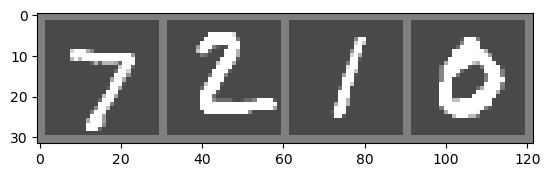

GroundTruth:      7     2     1     0


In [129]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{labels[j]:5}' for j in range(4)))

In [130]:
network = FCNetwork(input_dim=input_dim, num_classes=10)
network.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Reshape the input before sending it to the model.

In [131]:
print(images.reshape(batch_size, -1).shape[1])

784


In [132]:
# Reshape the images variable
images_reshaped = images.reshape(batch_size, -1)
outputs = network(images_reshaped)

In [133]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{predicted[j]:5}'
                              for j in range(4)))

# numbers represent number of classes --> happens bc of the loss functions (Least Squares, Cross Entropy)
# ten classes bc 0-9
# loss funcion reduces vector into probobilty that certain vectors fit into a certain class, vector of probabilties:
# [0.9, .1, 0,0.....] e.g.

Predicted:      7     2     1     0


#### Model evaluation
We have already trained our model. Next, we can evaluate its performance on the `test` set. We will use `accuracy` as the evaluation metric.

In [134]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
network.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        # Reshape the inputs
        images = images.reshape(batch_size, -1)
        outputs = network(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')
# how many times is the model predicting the right answer, 97% seems pretty good

Accuracy of the network on the test images: 97.11 %


### A Convolutional Neural Network
The network should have `two` convolution layers and `two` linear layers. The last `linear` layer should have `out_features = num_classes`.

We implement the following into the `forward()` function. All the processing happens in the forward function. We also use `F.relu` for the non-linearity:

* `conv1` should have in_channels = 1 (why) and out_channels = 10, kernel_size should be 5
* `conv2` should have in_channels = 10 and out_channels = 20, kernel_size should be 5
* Create a dropout layer. Use [Dropout2d](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html) for this task.  
* Create two max_pool layers, with kernel size 2. You have to use [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) class for this task.
* Flatten the input so that it can be processed by the linear layers 
* `fc1` should have in_features=320 (ask your tutors why), out_features = 50
* `fc2` should have out_features = num_classes

In [135]:
class CNNNetwork(nn.Module):
    def __init__(self):
        super(CNNNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 5)
        self.conv2 = nn.Conv2d(in_channels = 10, out_channels = 20, kernel_size = 5)
        self.conv2_drop = nn.Dropout2d()
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(in_features = 320, out_features = 50)
        self.fc2 = nn.Linear(in_features = 50, out_features = 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.max_pool1(x)
        # Apply ReLU
        x = F.relu(x)
        x = self.conv2_drop(x)
        
        x = self.conv2(x)
        x = self.max_pool2(x)
        # Apply ReLU
        x = F.relu(x)
        # Now flatten the input         
        x = x.view(-1, 320)
        x = self.fc1(x)
        # Apply ReLU
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
# CNNetworks treat the image into grid instead of 'rows', maintains locality structure

In [136]:
cnn_network = CNNNetwork()
params = list(cnn_network.parameters())

Next, we create an optimizer and the loss function for the `cnn_network`. We will use [CrossEntropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) as the loss function and [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD) as the optimizer.

Use a learning rate of `0.001` and play around with other parameters. Put `momentum` parameter as `0.9`.

In [137]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params = params, lr = 0.001, momentum=0.9)

In [138]:
PATH = '../../../files2large/mnist_cnn.pth'

#### Train the model
We train the model with the loop we have seen before:

In [139]:
def train_cnn_model(network, train_dataloader, val_dataloader, optimizer, criterion):
    min_val_loss = float("inf")
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        network.train()
        for i, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            optimizer.zero_grad() # now convolution, we don't have to reshape into vector

            outputs = network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0


        network.eval()
        val_loss = 0
        with torch.no_grad():
            for i, data in enumerate(val_dataloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data

                # forward + backward + optimize
                outputs = network(inputs)
                loss = criterion(outputs, labels)
                # print statistics
                val_loss += loss.item()
                if i % 2000 == 1999:    # print every 2000 mini-batches
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {val_loss / 2000:.3f}')
                    val_loss = 0.0
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            print(f"The new best model is at epoch {epoch}")
            torch.save(network.state_dict(), PATH)
        print(f'Epoch: {epoch} over')

In [140]:
train_cnn_model(network=cnn_network, train_dataloader=trainloader, val_dataloader=valloader,
                optimizer=optimizer, criterion=criterion)

[1,  2000] loss: 0.794
[1,  4000] loss: 0.251
[1,  6000] loss: 0.203
[1,  8000] loss: 0.169
[1, 10000] loss: 0.163
[1, 12000] loss: 0.148
[1,  2000] loss: 0.111
The new best model is at epoch 0
Epoch: 0 over
[2,  2000] loss: 0.133
[2,  4000] loss: 0.121
[2,  6000] loss: 0.109
[2,  8000] loss: 0.120
[2, 10000] loss: 0.114
[2, 12000] loss: 0.096
[2,  2000] loss: 0.080
The new best model is at epoch 1
Epoch: 1 over


In [141]:
cnn_network = CNNNetwork()
cnn_network.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [142]:
def evaluate_cnn_model(network, test_loader):
    correct = 0
    total = 0
    network.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = network(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct / total} %')
    
    return correct/total

# if one is smart, it is technichally possible to reach 99.5% with good parameter choice!

In [143]:
evaluate_cnn_model(network=cnn_network, test_loader=testloader)

Accuracy of the network on the test images: 98.21 %


0.9821

---
Now that we are experts, we perform a classification on the **CIFAR10 dataset**.

#### Load and normalize CIFAR10 dataset

In [144]:
# transform data to tensor
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# define batch size

batch_size = 4

# download data and load data in to dataloader

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_size = 0.8 # define train size

# split in train and validation set

train_size= int(train_size*len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

# load datasets into DataLoader

trainloader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


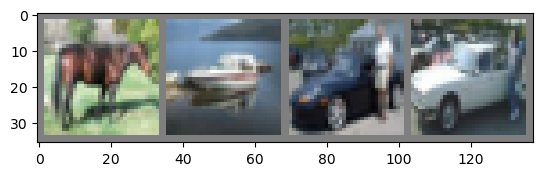

horse ship  car   car  


In [145]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Defining another convolutional Network

In [146]:
# building a network with two convolution an three linear layers

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3,out_channels =  6,kernel_size =  5)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5)
        self.fc1 = nn.Linear(in_features = 16 * 5 * 5, out_features = 120)
        self.fc2 = nn.Linear(in_features = 120, out_features = 84)
        self.fc3 = nn.Linear(in_features = 84, out_features = 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


network = Network()

#### Define loss criterion and optimizer

In [147]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params = network.parameters(), lr=0.001, momentum=0.9)

#### Train the network on training and validation set

In [148]:
def train_network(network, train_dataloader, val_dataloader, optimizer, criterion):
    min_val_loss = float("inf")
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        network.train()
        for i, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            optimizer.zero_grad() # now convolution, we don't have to reshape into vector

            outputs = network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0


        network.eval()
        val_loss = 0
        with torch.no_grad():
            for i, data in enumerate(val_dataloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data

                # forward + backward + optimize
                outputs = network(inputs)
                loss = criterion(outputs, labels)
                # print statistics
                val_loss += loss.item()
                if i % 2000 == 1999:    # print every 2000 mini-batches
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {val_loss / 2000:.3f}')
                    val_loss = 0.0
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            print(f"The new best model is at epoch {epoch}")
            torch.save(network.state_dict(), PATH)
        print(f'Epoch: {epoch} over')

In [149]:
train_network(network, trainloader, valloader, optimizer, criterion)

[1,  2000] loss: 2.220
[1,  4000] loss: 1.882
[1,  6000] loss: 1.695
[1,  8000] loss: 1.591
[1, 10000] loss: 1.536
[1,  2000] loss: 1.485
The new best model is at epoch 0
Epoch: 0 over
[2,  2000] loss: 1.444
[2,  4000] loss: 1.445
[2,  6000] loss: 1.388
[2,  8000] loss: 1.336
[2, 10000] loss: 1.335
[2,  2000] loss: 1.315
The new best model is at epoch 1
Epoch: 1 over


In [150]:
# save the model

PATH = '../../../files2large/cifar_net.pth'
torch.save(network.state_dict(), PATH)

#### Test the network on the test set

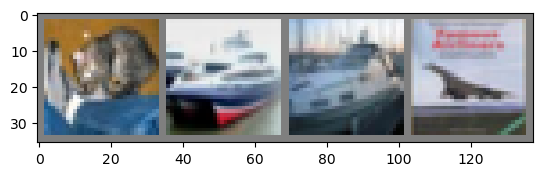

GroundTruth:  cat   ship  ship  plane


In [151]:
# Display a batch to get familier with test set

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [152]:
# command to reload saved neural network, in case ever needed in future

# network = Network()
# network.load_state_dict(torch.load(PATH))

# see what our network would predict

output = network(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   deer  dog   frog 


In [153]:
def eval_network(network, testloader):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = network(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [154]:
eval_network(network, trainloader)

Accuracy of the network on the 10000 test images: 55 %


Now, we use two different optimizers for training a CNN model on MNIST dataset. You just have to use a different optimizer and just re-use the training and evaluation code

In [155]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize( (0.1307,), (0.3081,))])

trainset = datasets.MNIST(root = 'MNIST', train = True, transform = transform, download = True)
testset = datasets.MNIST(root = 'MNIST', train = False, transform = transform, download = True)

batch_size = 4

# download data and load data in to dataloader

train_size = 0.8 # define train size

# split in train and validation set

train_size= int(train_size*len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

# load datasets into DataLoader

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [156]:
cnn_network = CNNNetwork()
params = list(cnn_network.parameters())

In [157]:
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(params = params, lr = 0.001)
optimizer2 = optim.Rprop(params = params, lr = 0.001)

In [158]:
train_cnn_model(cnn_network, trainloader, valloader, optimizer1, criterion)

[1,  2000] loss: 0.497
[1,  4000] loss: 0.215
[1,  6000] loss: 0.185
[1,  8000] loss: 0.163
[1, 10000] loss: 0.147
[1, 12000] loss: 0.123
[1,  2000] loss: 0.081
The new best model is at epoch 0
Epoch: 0 over
[2,  2000] loss: 0.129
[2,  4000] loss: 0.122
[2,  6000] loss: 0.113
[2,  8000] loss: 0.111
[2, 10000] loss: 0.113
[2, 12000] loss: 0.106
[2,  2000] loss: 0.073
The new best model is at epoch 1
Epoch: 1 over


In [159]:
accuracy_adam = evaluate_cnn_model(cnn_network, testloader)

Accuracy of the network on the test images: 97.95 %


In [160]:
cnn_network = CNNNetwork()
params = list(cnn_network.parameters())

In [161]:
train_cnn_model(cnn_network, trainloader, valloader, optimizer2, criterion)

[1,  2000] loss: 2.304
[1,  4000] loss: 2.304
[1,  6000] loss: 2.302
[1,  8000] loss: 2.303
[1, 10000] loss: 2.304
[1, 12000] loss: 2.303
[1,  2000] loss: 2.297
The new best model is at epoch 0
Epoch: 0 over
[2,  2000] loss: 2.303
[2,  4000] loss: 2.303
[2,  6000] loss: 2.304
[2,  8000] loss: 2.303
[2, 10000] loss: 2.304
[2, 12000] loss: 2.304
[2,  2000] loss: 2.297
Epoch: 1 over


In [162]:
accuracy_rprop = evaluate_cnn_model(cnn_network, testloader)

Accuracy of the network on the test images: 10.68 %


In [163]:
print(('The accuracy of a CNNetwork with Rprob ({}) used as optimizer \nis about a factor {} lower than the one with Adam ({})')
      .format(accuracy_rprop, round(accuracy_adam/accuracy_rprop,1), accuracy_adam))

The accuracy of a CNNetwork with Rprob (0.1068) used as optimizer 
is about a factor 9.2 lower than the one with Adam (0.9795)
